## Import Modules and Import Data

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error as mae
import os
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

C:\Users\Thu Pham\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print("Train data dimensions: ", df_train.shape)
print("Test data dimensions: ", df_test.shape)

Train data dimensions:  (188318, 132)
Test data dimensions:  (125546, 131)


## Explore and Prepare Data

In [3]:
# Store target variable of training data in a safe place
loss_train = df_train.loss

# Concatenate training and test sets
data = pd.concat([df_train.drop(['loss'], axis=1), df_test])

In [4]:
print("Number of missing values", data.isnull().sum().sum())

Number of missing values 0


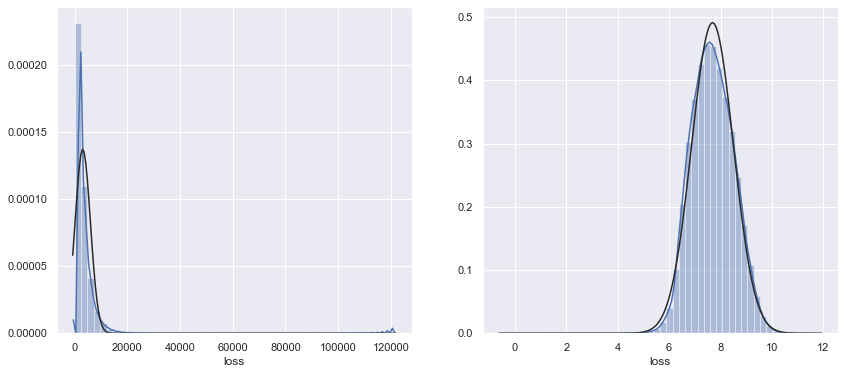

In [5]:
# Explore loss variable
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(loss_train, fit=norm, ax=ax1)
sns.distplot(np.log(loss_train), fit=norm, ax=ax2);

In [6]:
# Drop loss values that are greater than 40000
df_train = df_train.drop(df_train.loc[df_train['loss']>40000].index)
df_train.shape

(188295, 132)

In [7]:
# Use log transformation on loss
df_train['loss']=np.log(df_train['loss']+1)

In [8]:
# Concatenate training and test sets
data = pd.concat([df_train.drop(['loss'], axis=1), df_test])

In [9]:
# Convert categorical values to numerical values
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
for i in data:
    if 'cat' in i:
        data[i] = enc.fit_transform(data[i])
        
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,1,0,1,0,1,0,0,0,0,1,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,2,0,1,0,0,0,0,0,0,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,5,0,1,0,0,1,0,0,0,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,10,1,1,0,1,0,0,0,0,1,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,11,0,1,0,1,0,0,0,0,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [10]:
# Standardize Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
for i in data:
    if 'id' not in i:
        data[[i]] = sc.fit_transform(data[[i]])
        
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,1,-0.576157,1.144084,-0.24018,1.468458,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,-0.848815,1.104940,-0.841883,-0.923689,1.020872,1.811170,0.361613,0.482516,1.543250,0.984915
1,2,-0.576157,1.144084,-0.24018,-0.680986,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,1.905209,-0.255663,-0.273066,0.571812,-0.739267,-0.318449,-0.740599,-0.606445,0.551913,-0.859041
2,5,-0.576157,1.144084,-0.24018,-0.680986,1.382175,-0.654667,-0.157194,-0.250106,1.227329,...,-0.432640,-0.982433,-0.951221,-1.071098,-1.236987,-0.935587,-0.535400,-0.572503,-1.400693,1.252656
3,10,1.735638,1.144084,-0.24018,1.468458,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,-0.312109,-0.245789,-0.527749,-0.846675,-0.904184,-0.288972,-0.790115,-0.819798,0.522069,0.480723
4,11,-0.576157,1.144084,-0.24018,1.468458,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,1.036747,-1.525092,-1.332974,-1.209282,-1.456235,-1.538901,-1.376995,-1.389017,-1.164429,-0.283359


In [11]:
# Split data back into test and train datasets
data_train = data.iloc[:188295]
data_test = data.iloc[188295:]

In [12]:
# Split the data into train and validations sets by using train_test_split
X = data_train
y = df_train.loss
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

## Build Model

### Linear Regression

In [13]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.
from sklearn.feature_selection import RFECV
from sklearn import linear_model

estimator = linear_model.LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X_train, y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [14]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train.drop(["id"],axis= 1), y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_valid.drop(["id"],axis= 1))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred))
# The coefficient of determination
print('Coefficient of determination: %.4f'
      % r2_score(y_valid, y_pred))
# Mean Absolute Error
print('Mean absolute error: %.4f'
      % mae(y_valid, y_pred))

Mean squared error: 0.34
Coefficient of determination: 0.4830
Mean absolute error: 0.4569


### Ridge Regression

In [15]:
# Use RidgeCV to select the best alpha
from sklearn.linear_model import RidgeCV

alphas = 10**np.linspace(10,-2,100)*0.5

# Create ridge regression with different alpha values
regr_cv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)

# Fit the linear regression
model_cv = regr_cv.fit(X_train.drop(["id"],axis= 1), y_train)

# View alpha
model_cv.alpha_

0.005

In [16]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=model_cv.alpha_, normalize = True)
ridge_reg.fit(X_train.drop(["id"],axis= 1), y_train)

# Make predictions using the testing set
y_pred = ridge_reg.predict(X_valid.drop(["id"],axis= 1))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred))
# The coefficient of determination
print('Coefficient of determination: %.4f'
      % r2_score(y_valid, y_pred))
# Mean Absolute Error
print('Mean absolute error: %.4f'
      % mae(y_valid, y_pred))

Mean squared error: 0.34
Coefficient of determination: 0.4831
Mean absolute error: 0.4569


### Lasso Regression

In [17]:
# Use LassoCV to select the best alpha
from sklearn.linear_model import LassoCV

# Create lasso regression with different alpha values
regr_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)

# Fit the linear regression
model_cv = regr_cv.fit(X_train.drop(["id"],axis= 1), y_train)

# View alpha
model_cv.alpha_

1.0313055054715942e-06

In [18]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=model_cv.alpha_, normalize = True)
lasso_reg.fit(X_train.drop(["id"],axis= 1), y_train)

# Make predictions using the testing set
y_pred = lasso_reg.predict(X_valid.drop(["id"],axis= 1))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred))
# The coefficient of determination
print('Coefficient of determination: %.4f'
      % r2_score(y_valid, y_pred))
# Mean Absolute Error
print('Mean absolute error: %.4f'
      % mae(y_valid, y_pred))

Mean squared error: 0.34
Coefficient of determination: 0.4829
Mean absolute error: 0.4570


### ElasticNet

In [19]:
# Use ElasticNetCV to select the best alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV

# Create lasso regression with different alpha values
regr_cv = ElasticNetCV(cv = 10, normalize = True)

# Fit the linear regression
model_cv = regr_cv.fit(X_train.drop(["id"],axis= 1), y_train)

# View alpha
model_cv.alpha_

2.062611010943189e-06

In [20]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=model_cv.alpha_, l1_ratio=model_cv.l1_ratio_)
elastic_net.fit(X_train.drop(["id"],axis= 1), y_train)

# Make predictions using the testing set
y_pred = elastic_net.predict(X_valid.drop(["id"],axis= 1))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred))
# The coefficient of determination
print('Coefficient of determination: %.4f'
      % r2_score(y_valid, y_pred))
# Mean Absolute Error
print('Mean absolute error: %.4f'
      % mae(y_valid, y_pred))

Mean squared error: 0.34
Coefficient of determination: 0.4830
Mean absolute error: 0.4570


## Test Data

In [21]:
test_id = data_test['id']
data_test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,-0.576157,1.144084,-0.24018,-0.680986,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,-0.987135,-0.120922,-0.939253,0.629071,-0.781170,-0.635974,-0.552897,-0.589510,0.986944,-0.463303
1,6,-0.576157,1.144084,-0.24018,1.468458,-0.723497,-0.654667,-0.157194,-0.250106,1.227329,...,1.668963,-0.043829,-0.232866,1.135527,0.182540,0.568126,0.929757,0.869348,-0.190024,-1.292458
2,9,-0.576157,1.144084,-0.24018,1.468458,1.382175,-0.654667,6.361562,-0.250106,1.227329,...,1.104969,-1.358991,-0.893882,-0.948859,-0.781170,-1.038703,-1.183050,-1.200816,-1.105366,-0.891682
3,12,-0.576157,-0.874062,-0.24018,-0.680986,1.382175,-0.654667,-0.157194,-0.250106,-0.814777,...,-0.432640,-0.591551,-0.801011,-0.433929,-0.843200,-0.987548,-0.690330,-0.722976,0.461887,0.270928
4,15,1.735638,-0.874062,-0.24018,-0.680986,-0.723497,1.527494,-0.157194,-0.250106,-0.814777,...,-0.884129,-0.450685,-0.523799,-1.253204,-0.266128,0.038559,-0.639347,-0.673478,-0.903638,1.483620


In [22]:
prediction_ridge = ridge_reg.predict(data_test.drop(["id"],axis= 1))
prediction_ridge = np.exp(prediction_ridge)-1

prediction_linear = regr.predict(data_test.drop(["id"],axis= 1))
prediction_linear = np.exp(prediction_linear)-1

prediction_lasso = lasso_reg.predict(data_test.drop(["id"],axis= 1))
prediction_lasso = np.exp(prediction_lasso)-1

prediction_elastic = elastic_net.predict(data_test.drop(["id"],axis= 1))
prediction_elastic = np.exp(prediction_elastic)-1

In [23]:
submission_linear = pd.DataFrame(test_id)
submission_linear['loss'] = prediction_linear

submission_ridge = pd.DataFrame(test_id)
submission_ridge['loss'] = prediction_ridge

submission_lasso = pd.DataFrame(test_id)
submission_lasso['loss'] = prediction_lasso

submission_elastic = pd.DataFrame(test_id)
submission_elastic['loss'] = prediction_elastic

In [24]:
submission_linear.to_csv('Submission_Linear.csv', index = False)
submission_lasso.to_csv('Submission_Lasso.csv', index = False)
submission_elastic.to_csv('Submission_Elastic.csv', index = False)
submission_ridge.to_csv('Submission_Ridge.csv', index = False)

## Kaggle Results

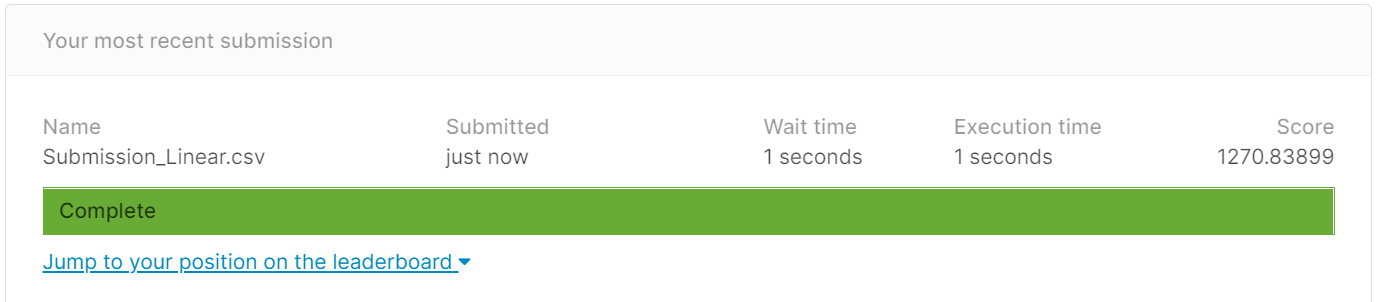

In [30]:
from PIL import Image

# Linear Regression
path_Linear = "Linear_Submission.PNG"
img_Linear  = Image.open(path_Linear) 
img_Linear

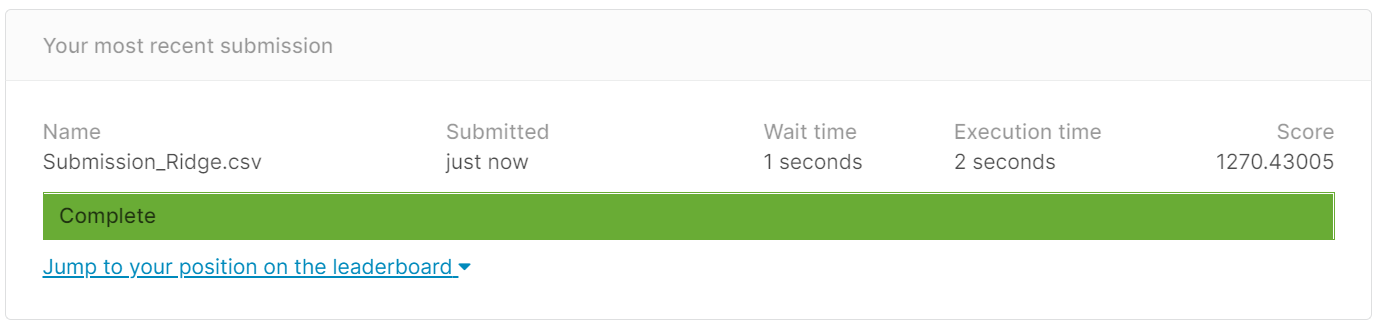

In [32]:
# Ridge Regression
path_Ridge = "Ridge_Submission.PNG"
img_Ridge  = Image.open(path_Ridge) 
img_Ridge

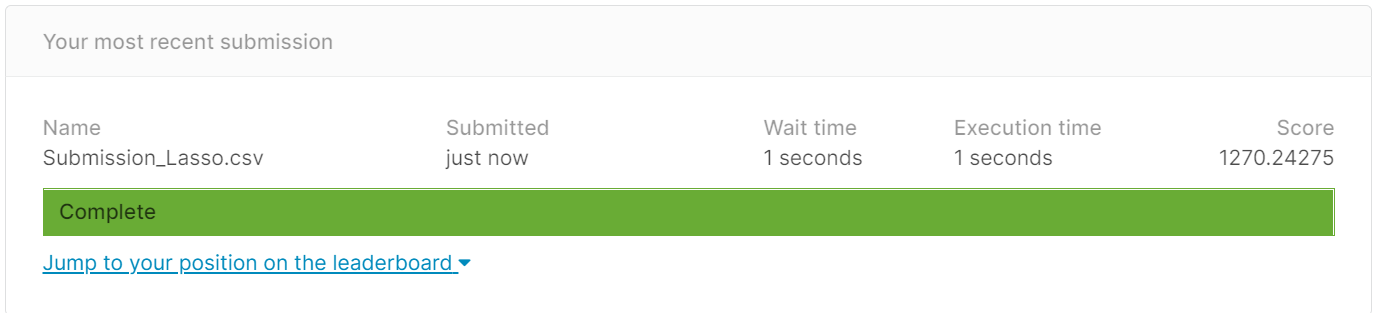

In [33]:
# Lasso Regression
path_Lasso = "Lasso_Submission.PNG"
img_Lasso  = Image.open(path_Lasso) 
img_Lasso

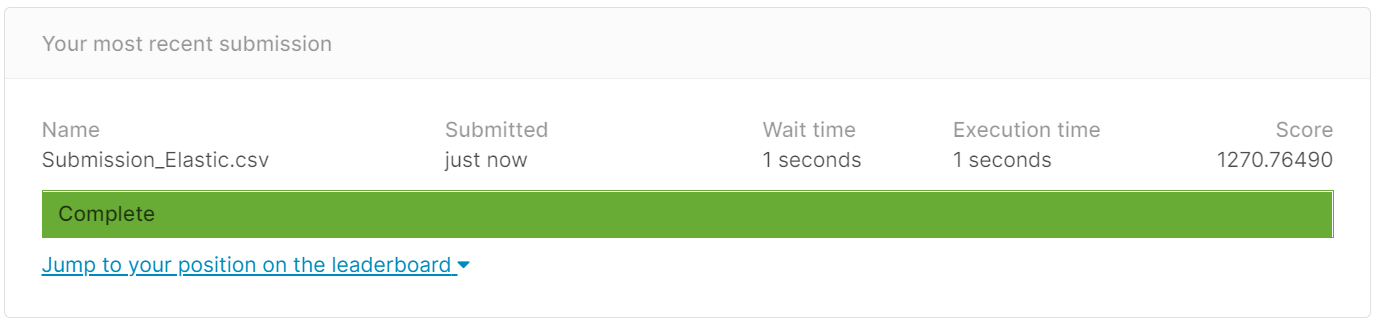

In [34]:
# ElasticNet Regression
path_ElasticNet = "ElasticNet_Submission.PNG"
img_ElasticNet  = Image.open(path_ElasticNet) 
img_ElasticNet

Among 4 regressions, Lasso performs the best with the score of 1270.24275. Linear Regression with all features selected performs the worst with the score of 1270.83899. Ridge is ranked second with the score of 1270.43005, and ElasticNet is ranked third with the score 1270.76490.

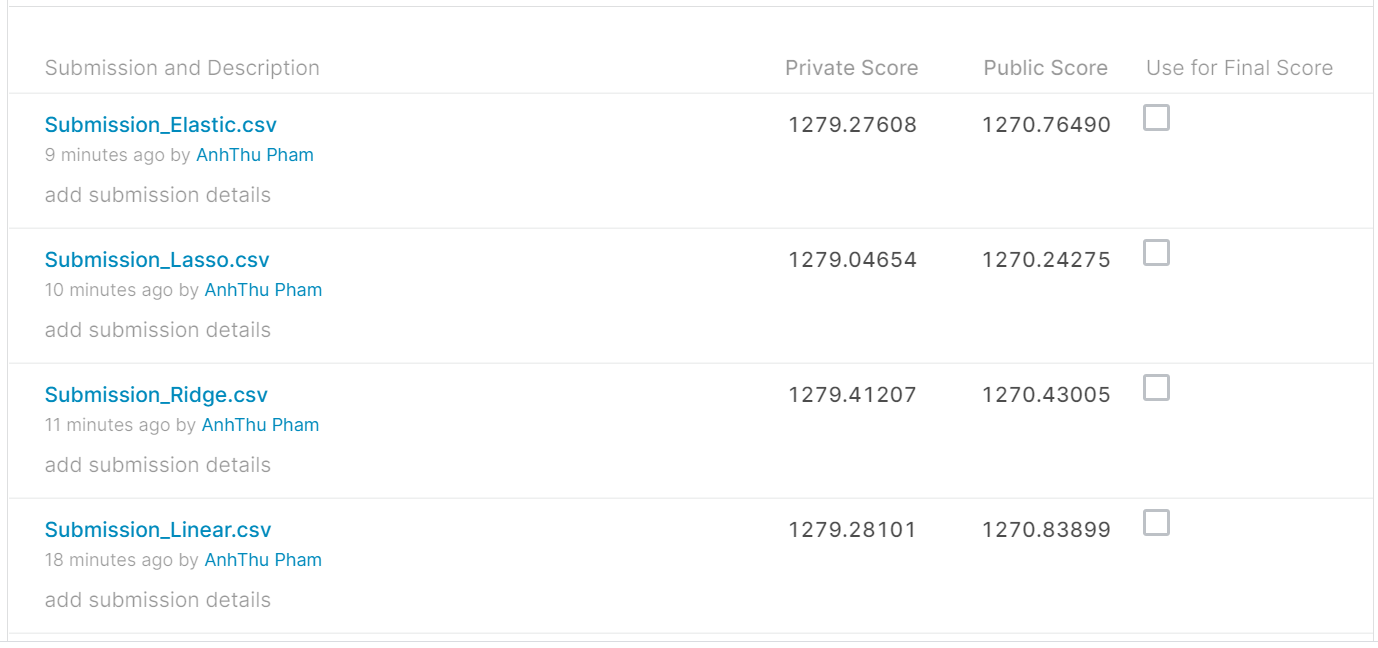

In [35]:
# All Scores
path_all = "All_Scores.PNG"
img_all  = Image.open(path_all) 
img_all